<h1>Kaggle Lending Club</h1>
<h2>Spécification du problème</h2>

<h3>Variables</h3>
<ol>
   <li>Variables liées au crédit : <br/>
      <b>loan_amnt</b>	      The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.<br/>
      <b>funded_amnt</b>	      The total amount committed to that loan at that point in time.<br/>
      <b>funded_amnt_inv</b>	  The total amount committed by investors for that loan at that point in time.<br/>
      <b>term</b>               The number of payments on the loan. Values are in months and can be either 36 or 60.<br/>
      <b>int_rate</b>	          Interest Rate on the loan<br/>
      <b>installment</b>	      The monthly payment owed by the borrower if the loan originates.<br/>
      <b>grade</b>	          LC assigned loan grade<br/>
      <b>sub_grade</b>	      LC assigned loan subgrade<br/>
      <b>issue_d</b>	The month which the loan was funded
      <b>loan_status</b>	Current status of the loan
      <b>pymnt_plan</b>	Indicates if a payment plan has been put in place for the loan
      <b>purpose</b>	A category provided by the borrower for the loan request. 
      <b>initial_list_status</b>	The initial listing status of the loan. Possible values are – W, F
      <b>last_pymnt_d</b>	Last month payment was received
   </li>
   <li> Variables liées à l'emprunteur  : <br/>
      <b>emp_title</b>	The job title supplied by the Borrower when applying for the loan.<br/>
      <b>emp_length</b>	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. <br/>
      <b>home_ownership</b>	The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.<br/>
      <b>annual_inc</b>	The self-reported annual income provided by the borrower during registration.<br/>
      <b>verification_status</b>	Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified<br/>
   <b>zip_code</b>	The first 3 numbers of the zip code provided by the borrower in the loan application.<br/>
   <b>addr_state</b>	The state provided by the borrower in the loan application<br/>
   </li>
   <li> Variables liées à la qualité de l'emprunteur  : <br/>
      <b>dti</b>	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.<br/>
      <b>delinq_2yrs</b>	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years<br/>
      <b>earliest_cr_line</b>	The month the borrower's earliest reported credit line was opened<br/>
      <b>inq_last_6mths</b>	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)<br/>
      <b>mths_since_last_delinq</b>	The number of months since the borrower's last delinquency.<br/>
      <b>mths_since_last_record</b>	The number of months since the last public record.<br/>
      <b>open_acc</b>	The number of open credit lines in the borrower's credit file.<br/>
      <b>pub_rec</b>	Number of derogatory public records<br/>
   </li>
</ol>

<h2>Analyse &amp; cleaning des données fournies</h2>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Display configuration
pd.options.display.max_columns = 100
%matplotlib inline

#Load and format data
df_data = pd.read_csv(
            '../inputs/loan.csv', low_memory = False,
            dtype = {'term':np.str},
            parse_dates = 
                [
                    'last_pymnt_d', 'earliest_cr_line', 'issue_d', 'term', 'last_credit_pull_d'
                ]
            )

df_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,2015-01-01,171.62,NaN,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,NaN,2013-09-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,2014-06-01,649.91,NaN,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,2015-01-01,357.48,NaN,2015-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,2016-01-01,67.79,Feb-2016,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df_data_save = df_data.copy(deep=True)

In [3]:
df_data = df_data_save.copy(deep=True)

In [4]:
df_data.shape

(887379, 74)

De nombreuses colonnes présentent des données manquantes (NaN) :<br/>

In [5]:
pd.options.display.max_columns = 100
pd.isnull(df_data).sum().tail()

all_util            866007
total_rev_hi_lim     70276
inq_fi              866007
total_cu_tl         866007
inq_last_12m        866007
dtype: int64

In [6]:
col_todrop = df_data.columns[pd.isnull(df_data).sum() > 0.9 * df_data.shape[0]].tolist()
col_todrop

['annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [7]:
df_data.drop(col_todrop,
            axis=1, inplace=True);

Colonnes à formater : term, grade / subgrade, emp_length

In [8]:
df_data['term'] = df_data['term'].apply(lambda x: x[0:3])
df_data['term'] = pd.to_numeric(df_data['term'])

In [9]:
df_data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)

In [10]:
emp2float = {
    '10+ years':11, '< 1 year':0, '1 year':1, '3 years':3,
    '8 years':8, '9 years':9, '4 years':4, '5 years':5, 
    '6 years':6, '2 years':2, '7 years':7, 'n/a':-1
}

df_data['emp_length']=df_data['emp_length'].fillna('n/a')
df_data['emp_length'] = df_data['emp_length'].apply(lambda x: emp2float[x])
#df_data['emp_length'] = df_data['emp_length'].apply(lambda x: emp2float[x])

Colonnes non exploitables sans un traitement complexe ou supprimées par simplification :

In [11]:
df_data.drop(
    [
        'url', 'desc', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
        'total_rev_hi_lim', 'verification_status', 'revol_bal', 'revol_util',
        'initial_list_status','collections_12_mths_ex_med',
        'mths_since_last_major_derog', 'policy_code', 'application_type'
    ],
    axis=1, inplace=True
    );

In [12]:
df_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d'],
      dtype='object')

Suppression des entrées où il manque une variable importante :

In [13]:
df_data = df_data.where(~df_data['loan_amnt'].isnull())
df_data = df_data.where(~df_data['term'].isnull())
df_data = df_data.where(~df_data['int_rate'].isnull())
df_data = df_data.where(~df_data['loan_status'].isnull())
df_data = df_data.where(~df_data['total_pymnt'].isnull())
df_data = df_data.where(~df_data['issue_d'].isnull())
df_data = df_data.where(~df_data['last_pymnt_d'].isnull())

<h3>Cohérence des données / Data Cleaning</h3>

<h4>Variables continues</h4>

In [14]:
df_data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt
count,8.697200e+05,8.697200e+05,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000,8.697160e+05,869720.000000,869691.000000,869691.000000,423878.000000,133805.000000,869691.000000,869691.000000,869691.000000,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000,869720.000000
mean,3.178047e+07,3.427270e+07,14748.057478,14734.398686,14694.558699,43.198869,13.261159,436.639840,5.988118,7.496605e+04,18.129744,0.313756,0.695654,34.069966,70.229857,11.538111,0.194279,25.263986,8274.455087,8271.097407,7711.614868,7673.195662,5874.612253,1790.434288,0.404746,46.163583,4.914001,2208.086908
std,2.250629e+07,2.376448e+07,8425.968707,8420.279574,8432.879782,10.997694,4.382184,243.965253,4.262411,6.444023e+04,17.278153,0.861210,0.999943,21.888332,28.205463,5.305942,0.580297,11.831683,8431.194031,8427.793027,7876.375500,7851.489682,6640.856656,2101.397203,4.128722,408.853196,63.270347,4833.188772
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,36.000000,5.320000,15.670000,-1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.001110e+06,1.075277e+07,8000.000000,8000.000000,8000.000000,36.000000,9.990000,260.850000,2.000000,4.500000e+04,11.890000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,17.000000,0.000000,0.000000,2047.630000,2030.797500,1293.190000,472.540000,0.000000,0.000000,0.000000,290.370000
50%,3.321119e+07,3.584487e+07,13000.000000,13000.000000,13000.000000,36.000000,12.990000,382.550000,6.000000,6.473400e+04,17.630000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,24.000000,6295.625000,6292.540000,5054.610000,5023.540000,3338.080000,1106.145000,0.000000,0.000000,0.000000,471.290000
75%,5.355463e+07,5.707558e+07,20000.000000,20000.000000,20000.000000,60.000000,16.200000,572.190000,11.000000,9.000000e+04,23.910000,0.000000,1.000000,50.000000,92.000000,14.000000,0.000000,32.000000,13495.840000,13489.560000,10788.700455,10725.350000,8000.000000,2274.732500,0.000000,0.000000,0.000000,846.765000
max,6.861687e+07,7.351969e+07,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1445.460000,11.000000,9.500000e+06,9999.000000,39.000000,33.000000,188.000000,129.000000,90.000000,86.000000,169.000000,49372.860000,49372.860000,57777.579870,57777.580000,35000.030000,24205.620000,358.680000,33520.270000,7002.190000,36475.590000


Structure des prêts :<br/>
869720 &#36; ont été investis entre 2007 et 2015<br/>
avec un montant de crédit de 14.734&#36; en moyenne<br/>
50 des prêts sont accordés pour des montants entre 8000 et 20.000&#36;<br/>
Le montant maximalaccordé est de 35.000&#36;

Le revenu maximal (annual_inc) est de 9.500.000 ce qui pourrait indiquer la présence de données abberantes sur cette variable.<br/> Pour vérifier simplement, on regarde la donnée conjointe du salaire et de la durée de l''emploi :

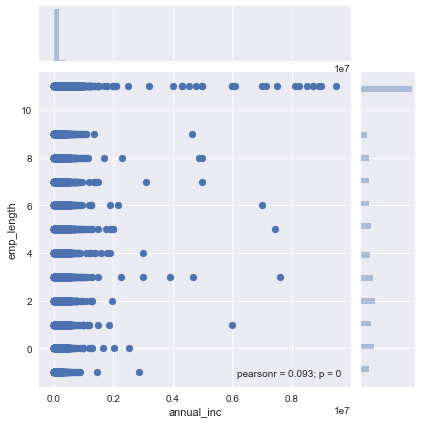

In [60]:
sns.jointplot(x=df_data['annual_inc'], y=df_data['emp_length'])

On retient que le revenu indiqué présente certaines valeurs abberantes.<br/>
Par exemple, pour une durée d''emploi inférieure à 1 an, on concoit mal les valeurs de salaire annuelle de 200.000$ qui apparaissent sur le graphique.

On vérifie la cohérence des différents montants enregistrés pour les paiements :

In [16]:
pymnt_diff = df_data['total_pymnt'] - df_data['total_rec_prncp'] - df_data['total_rec_int'] \
    - df_data['total_rec_late_fee'] - df_data['recoveries'] - df_data['collection_recovery_fee']
(pymnt_diff>1).sum()

0

On vérifie la cohérence entre la notation du crédit (grade) et le taux d''intérêt :

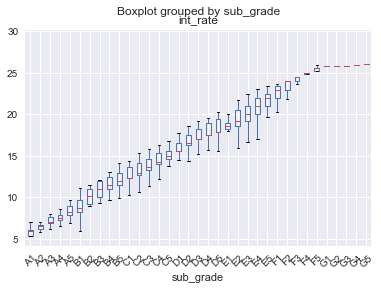

In [18]:
#dfplt = df_data.boxplot(column='int_rate', by='grade')
#dfplt.set_xticklabels(labels=dfplt.get_xticklabels(), rotation=45);

dfplt = df_data.boxplot(column='int_rate', by='sub_grade')
dfplt.set_xticklabels(labels=dfplt.get_xticklabels(), rotation=45);

<h4>Dates</h4>

Conversion des dates en données visualisables :

In [19]:
df_data['last_pymnt_y'] = df_data['last_pymnt_d'].apply(lambda x: x.year)
df_data['issue_y'] = df_data['issue_d'].apply(lambda x: x.year)
#df_data['last_credit_pull_y']=df_data['last_credit_pull_d'].apply(lambda x: x.year)

In [20]:
df_data['issue_d'].describe()

count                  869720
unique                    103
top       2015-10-01 00:00:00
freq                    48593
first     2007-06-01 00:00:00
last      2015-12-01 00:00:00
Name: issue_d, dtype: object

In [21]:
df_data['last_pymnt_d'].describe()

count                  869720
unique                     98
top       2016-01-01 00:00:00
freq                   470150
first     2007-12-01 00:00:00
last      2016-01-01 00:00:00
Name: last_pymnt_d, dtype: object

Les données contiennent donc des crédits émis depuis le 1er juin 2007 jusqu''au 1er décembre 2015.<br/> Le dernier paiement a lieu le 1er janvier 2016. <br/>
Donc pour de nombreux crédits (Current), on ne connait pas l'issue (défaut vs payé) du crédit.<br/>
Voir graph suivant :

In [64]:
df_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', nan, 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'], dtype=object)

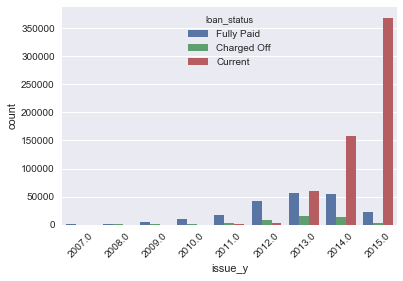

In [61]:
df_data3stat = df_data[df_data['loan_status'].isin(['Current','Fully Paid', 'Charged Off'])]
plt1 = sns.countplot(x="issue_y", data=df_data3stat, hue='loan_status', orient='h')
plt1.set_xticklabels(labels=plt1.get_xticklabels(), rotation=45);

On travaillera sur l'ensemble des données pour obtenir des statistiques générales et également pour comprendre la dynamique des emprunts courants (loan_status=Current,'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)').<br/>
Pour analyser le retour sur investissement, il faudra travailler sur une période de temps où les loans sont arrivés à leur terme (payés ou impayés) :

In [23]:
df_data['effective_term'] = df_data['last_pymnt_d'] - df_data['issue_d']
df_data['pymnt_duration'] = ((df_data['effective_term'] / np.timedelta64(1, 'M')).round())
df_data['pymnt_delay']=df_data['pymnt_duration']-df_data['term']

df_valid_data = df_data[  ( (df_data['loan_status'].isin(['Fully Paid', 'Charged Off'])) &
                ( (df_data['issue_d'] < np.datetime64('2012-06-01')) & (df_data['term']==36) ) 
                | ( (df_data['issue_d'] < np.datetime64('2010-06-01')) & (df_data['term']==60) ) ) ].copy(deep=True)


<h3> Structure du crédit </h3>

Evolution exponentielle du volume des emprunts émis :

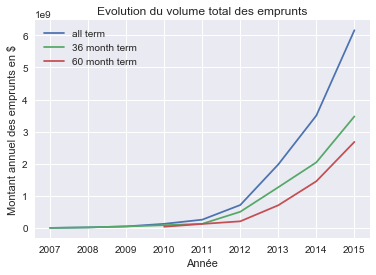

In [24]:
total_loan = pd.Series(df_data.groupby('issue_y')['loan_amnt'].sum())
plt.plot(total_loan, label='all term')

total_loan36 = pd.Series(df_data[df_data['term']==36].groupby('issue_y')['loan_amnt'].sum())
plt.plot(total_loan36, label='36 month term')

total_loan60 = pd.Series(df_data[df_data['term']==60].groupby('issue_y')['loan_amnt'].sum())
plt.plot(total_loan60, label='60 month term')

plt.title('Evolution du volume total des emprunts')
plt.xlabel('Année')
plt.ylabel('Montant annuel des emprunts en $')
plt.legend()
plt.show()

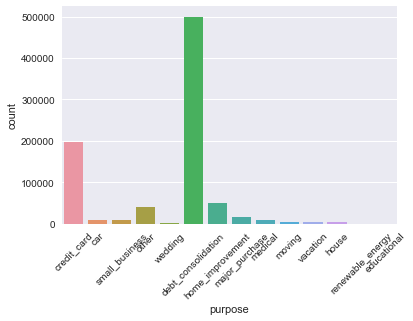

In [25]:
plt1 = sns.countplot(x="purpose", data=df_data2disp,  orient='h')
plt1.set_xticklabels(labels=plt1.get_xticklabels(), rotation=45);

<h3>Emprunteurs</h3>

In [36]:
#df_data.head()

<h3>Etude de l'investissement</h3>

Le retour sur investissement réél dépend de :<br/>
- taux d''intérêts (int_rate)
- les retards de paiements (pyment_delay)
- l'arrêt ou la poursuite du rembourssement jusqu'au plus proche de son terme (loan_status)
<br/>
On créer une variable qui permet d'évaluer le retard en mois sur les crédits totalement payés.

In [49]:
df_valid_data['gain'] = df_valid_data['total_pymnt'] - df_valid_data['loan_amnt']
df_valid_data['relative_gain'] = df_valid_data['gain']  / df_valid_data['loan_amnt']*100

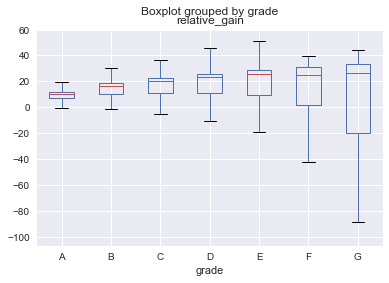

In [76]:
#Quel est le retour sur investissement de chaque prêt? Total/Annuel/Mensuel
plt.figure()
df_valid_data.boxplot(column='relative_gain', by='grade')
plt.show()

On remarque naturellement que plus la notation du crédit est élevée, plus le gain médian augmente mais avec un risque plus élevé (écart interquartile élevé)

On calcule le gain annuel en % :

In [75]:
T = df_valid_data['pymnt_duration']
G = df_valid_data['relative_gain']
I = df_valid_data['loan_amnt']
NAR = (np.power(np.abs((G / 100 + 1)),12 / T) - 1) * ((G > 0) - 0.5) * 2 * 100
NAR = NAR.replace([np.inf, -np.inf], 0)
df_valid_data['NAR'] = NAR
df_valid_data['NAR'].mean()

11.117088594956977

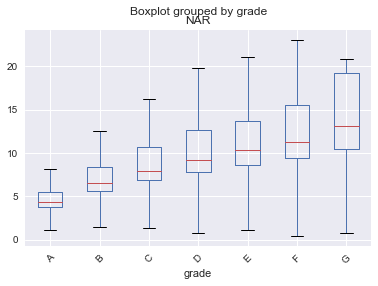

In [66]:
plt.figure()
df_valid_data.boxplot(column='NAR', by='grade', showfliers=False)
plt.show()

Il est également utile de savoir s'il existe des types (purpose) d''investissements plus risqués. Ci-dessous, les emprunts pour énergies renouvelables sont plus risqués que ceux pour l'achat de voitures.

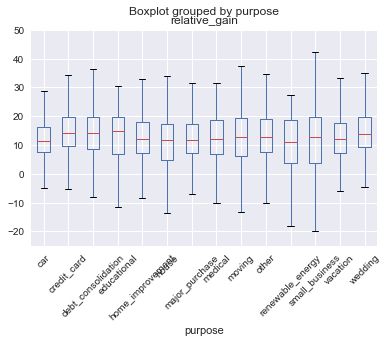

In [74]:
plt.figure()
plt1 = df_valid_data.boxplot(column='relative_gain', by='purpose')
plt1.set_xticklabels(labels=plt1.get_xticklabels(), rotation=45);
axes = plt.gca()
axes.set_ylim([-25,50])
plt.show()